In [198]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import norm
from scipy.optimize import fsolve
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Calculating Implied Volatility using Black-Scholes

Current AAPL stock price: 172.21499633789062
Strike Price: 172.5  Implied Volatility: 0.2144485486430617  Market Prx:  2.1399999999999997
Strike Price: 175.0  Implied Volatility: 0.20918435982957284  Market Prx:  1.0950000000000002
Strike Price: 180.0  Implied Volatility: 0.21325770666958546  Market Prx:  0.22
Strike Price: 185.0  Implied Volatility: 0.23929358179508445  Market Prx:  0.055


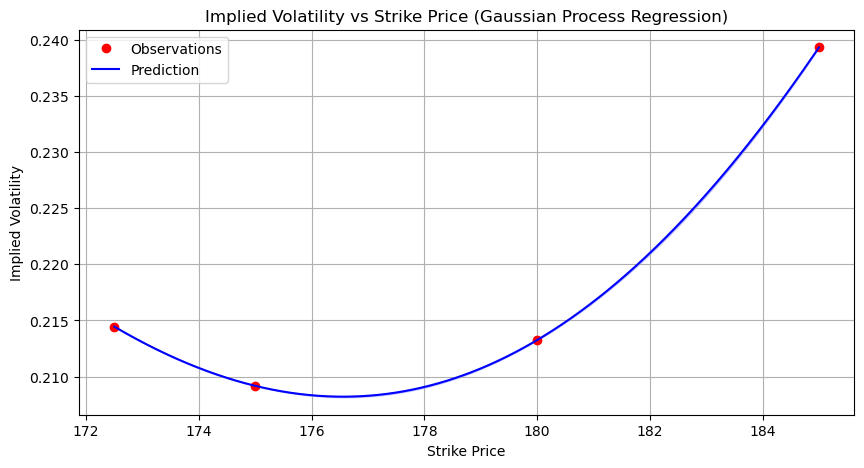

In [199]:
def calculate_implied_volatility(S, K, T, r, price):
    def f(sigma):
        d1 = (1 / (sigma * T ** 0.5)) * (np.log(S / K) + (r + (sigma ** 2) / 2) * T)
        d2 = d1 - sigma * T ** 0.5
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2) - price

    return fsolve(f, 0.5, maxfev=1000)[0]

def main():
    # Fetch stock data for AAPL
    stock = yf.Ticker("AAPL")
    current_price = stock.history(period='1d').iloc[-1]['Close']
    print("Current AAPL stock price:", current_price)

    # Specify expiry date as a string
    expiry_date = "2024-04-05"

    # Calculate time to expiry
    from datetime import datetime
    today = datetime.now()
    expiry_date_obj = datetime.strptime(expiry_date, "%Y-%m-%d")
    time_to_expiry = (expiry_date_obj - today).days / 366

    # Fetch call options data for AAPL with the specified expiry date
    options = stock.option_chain(expiry_date).calls

    # Filter options with open interest more than 10000 and ask price greater than 0
    options = options[(options['openInterest'] > 10000) & (options['bid'] > 0)]

    # Calculate implied volatility for filtered options
    implied_volatilities = []
    for index, option in options.iterrows():
        strike_price = option['strike']
        option_price = (option['ask'] + option['bid']) / 2
        risk_free_rate = 0.055  # Assume a risk-free rate for calculation
        implied_volatility = calculate_implied_volatility(current_price, strike_price, time_to_expiry, risk_free_rate, option_price)
        implied_volatilities.append(implied_volatility)
        print("Strike Price:", strike_price, " Implied Volatility:", implied_volatility, " Market Prx: ", option_price)

    # Perform Gaussian Process Regression
    X = options[['strike']].values
    y = np.array(implied_volatilities)

    # Gaussian Process Regression
    kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(X, y)

    # Predict using the Gaussian Process model
    x_pred = np.linspace(X.min()-0*5, X.max()+0*5, 1000).reshape(-1, 1)
    y_pred, sigma = gp.predict(x_pred, return_std=True)

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(X, y, 'ro', label='Observations')
    plt.plot(x_pred, y_pred, 'b-', label='Prediction')
    plt.fill_between(x_pred.flatten(), (y_pred - 1.96 * sigma).flatten(), (y_pred + 1.96 * sigma).flatten(), alpha=0.2, color='blue')
    plt.title("Implied Volatility vs Strike Price (Gaussian Process Regression)")
    plt.xlabel("Strike Price")
    plt.ylabel("Implied Volatility")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()


# Calculating Implied Volatility using Neural Network Regression

In [200]:
stock = yf.Ticker("AAPL")
current_price = stock.history(period='1d').iloc[-1]['Close']
expiry_date = "2024-04-05"
options = stock.option_chain(expiry_date).calls

In [201]:
# Filter options with open interest more than 10000 and ask price greater than 0
#options = options[(options['openInterest'] > 1000) & (options['bid'] > 0)]
# Calculate time to expiry
today = datetime.now()
expiry_date_obj = datetime.strptime(expiry_date, "%Y-%m-%d")
time_to_expiry = (expiry_date_obj - today).days / 366

In [202]:
options

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL240405C00100000,2024-03-26 13:57:10+00:00,100.0,70.85,72.25,72.80,0.000000,0.000000,1,2,1.650392,True,REGULAR,USD
1,AAPL240405C00105000,2024-03-27 13:36:22+00:00,105.0,65.90,67.20,67.75,-11.400002,-14.747737,2,0,1.476565,True,REGULAR,USD
2,AAPL240405C00120000,2024-03-08 15:11:44+00:00,120.0,51.72,52.30,52.70,0.000000,0.000000,1,1,1.137700,True,REGULAR,USD
3,AAPL240405C00125000,2024-03-04 19:59:06+00:00,125.0,51.05,47.30,47.85,0.000000,0.000000,2,1,1.069341,True,REGULAR,USD
4,AAPL240405C00130000,2024-03-13 19:42:28+00:00,130.0,42.00,42.30,42.80,0.000000,0.000000,120,120,0.944336,True,REGULAR,USD
5,AAPL240405C00135000,2024-03-25 15:10:30+00:00,135.0,37.00,37.40,37.85,1.169998,3.265415,3,10,0.870118,True,REGULAR,USD
6,AAPL240405C00140000,2024-03-27 14:28:51+00:00,140.0,32.27,32.35,32.85,1.820000,5.977010,1,15,0.751956,True,REGULAR,USD
7,AAPL240405C00145000,2024-03-25 13:47:43+00:00,145.0,25.28,27.40,27.80,0.000000,0.000000,3,16,0.646000,True,REGULAR,USD
8,AAPL240405C00146000,2024-03-27 14:09:23+00:00,146.0,27.25,26.35,26.85,3.000000,12.371134,4,5,0.625004,True,REGULAR,USD
9,AAPL240405C00149000,2024-03-22 19:05:36+00:00,149.0,24.30,23.50,23.70,0.000000,0.000000,1,1,0.562504,True,REGULAR,USD


In [203]:
risk_free_rate = 0.055  # Assume a risk-free rate for calculation

In [204]:
X = options[["strike", "lastPrice", "bid", "ask", "change", "percentChange", "volume", "openInterest"]]
X["volume"].fillna(0, inplace=True)
y = options[["impliedVolatility"]]

/var/folders/p0/hzvply8x0d1664mt9zx_t7nw0000gn/T/ipykernel_1023/815444601.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["volume"].fillna(0, inplace=True)


In [205]:
X["risk_free_rata"] = 0.055
X["time_to_expiry"] = time_to_expiry 

/var/folders/p0/hzvply8x0d1664mt9zx_t7nw0000gn/T/ipykernel_1023/3834623889.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["risk_free_rata"] = 0.055
/var/folders/p0/hzvply8x0d1664mt9zx_t7nw0000gn/T/ipykernel_1023/3834623889.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["time_to_expiry"] = time_to_expiry


In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [207]:
#X_train = X
#y_train = y

In [208]:
'''expiry_date = "2024-04-05"
options = stock.option_chain(expiry_date).calls
# Filter options with open interest more than 10000 and ask price greater than 0
options = options[(options['openInterest'] > 1000) & (options['bid'] > 0)]
# Calculate time to expiry
today = datetime.now()
expiry_date_obj = datetime.strptime(expiry_date, "%Y-%m-%d")
time_to_expiry = (expiry_date_obj - today).days / 366
risk_free_rate = 0.055  # Assume a risk-free rate for calculation
X = options[["strike", "lastPrice", "bid", "ask", "change", "percentChange", "volume", "openInterest"]]
X["volume"].fillna(0, inplace=True)
y = options[["impliedVolatility"]]
X["risk_free_rata"] = 0.055
X["time_to_expiry"] = time_to_expiry 
X_test = X
y_test = y'''

'expiry_date = "2024-04-05"\noptions = stock.option_chain(expiry_date).calls\n# Filter options with open interest more than 10000 and ask price greater than 0\noptions = options[(options[\'openInterest\'] > 1000) & (options[\'bid\'] > 0)]\n# Calculate time to expiry\ntoday = datetime.now()\nexpiry_date_obj = datetime.strptime(expiry_date, "%Y-%m-%d")\ntime_to_expiry = (expiry_date_obj - today).days / 366\nrisk_free_rate = 0.055  # Assume a risk-free rate for calculation\nX = options[["strike", "lastPrice", "bid", "ask", "change", "percentChange", "volume", "openInterest"]]\nX["volume"].fillna(0, inplace=True)\ny = options[["impliedVolatility"]]\nX["risk_free_rata"] = 0.055\nX["time_to_expiry"] = time_to_expiry \nX_test = X\ny_test = y'

In [209]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [210]:
reg = MLPRegressor(hidden_layer_sizes=(8, 8), activation='relu', solver='adam', random_state = 0)
reg.fit(X_train_scaled, y_train)

/Users/abhisheksharma/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/abhisheksharma/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(8, 8), random_state=0)

In [211]:
# Make prediction and evaluate error
y_pred = reg.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.007927851222085417


In [212]:
y_pred

array([0.47482269, 0.18423405, 0.36893152, 0.4432289 , 0.38496191,
       0.51261221, 0.97263287, 0.44702685, 0.63667444, 1.07020928,
       0.72965028, 0.32464768, 0.41321196, 0.41043284, 0.34804573,
       0.45172683, 0.58277144, 0.53118451, 0.5031632 , 0.3439186 ,
       0.34254637, 0.31353063])

In [213]:
y_test

,impliedVolatility
37,0.531255
24,0.219734
25,0.238289
36,0.515630
34,0.429693
39,0.593754
4,0.944336
12,0.485601
8,0.625004
3,1.069341


In [214]:
df = pd.DataFrame({'y_test': y_test["impliedVolatility"], 'Predictions': y_pred})

In [215]:
df.sort_index(axis = 0)

,y_test,Predictions
3,1.069341,1.070209
4,0.944336,0.972633
6,0.751956,0.729650
8,0.625004,0.636674
9,0.562504,0.503163
12,0.485601,0.447027
13,0.419439,0.451727
15,0.339362,0.531185
16,0.284675,0.343919
17,0.242195,0.348046


In [216]:
X_test["ImpliedVolatility"] = y_test

In [217]:
X_test["Predictions"] = y_pred

In [218]:
X_test = X_test.sort_index()

In [219]:
X_test

,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,risk_free_rata,time_to_expiry,ImpliedVolatility,Predictions
3,125.0,51.05,47.30,47.85,0.00,0.000000,2,1,0.055,0.021858,1.069341,1.070209
4,130.0,42.00,42.30,42.80,0.00,0.000000,120,120,0.055,0.021858,0.944336,0.972633
6,140.0,32.27,32.35,32.85,1.82,5.977010,1,15,0.055,0.021858,0.751956,0.729650
8,146.0,27.25,26.35,26.85,3.00,12.371134,4,5,0.055,0.021858,0.625004,0.636674
9,149.0,24.30,23.50,23.70,0.00,0.000000,1,1,0.055,0.021858,0.562504,0.503163
12,155.0,17.40,17.65,17.80,1.25,7.739938,3,39,0.055,0.021858,0.485601,0.447027
13,157.5,15.10,15.10,15.25,2.05,15.708814,7,39,0.055,0.021858,0.419439,0.451727
15,162.5,10.27,10.25,10.45,0.92,9.839573,17,66,0.055,0.021858,0.339362,0.531185
16,165.0,8.16,7.85,8.00,2.46,43.157898,259,959,0.055,0.021858,0.284675,0.343919
17,167.5,5.70,5.55,5.70,1.89,49.606297,497,834,0.055,0.021858,0.242195,0.348046


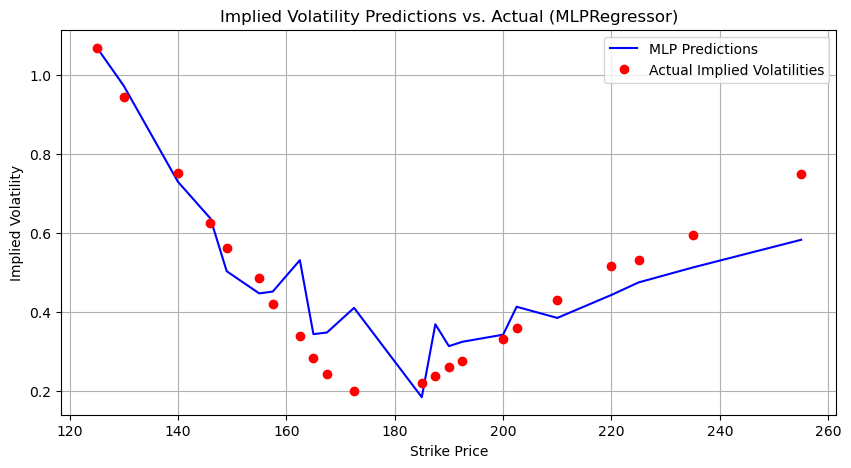

In [220]:
# Sort together for smooth plotting 
data = zip(X_test["strike"],X_test["Predictions"], X_test["ImpliedVolatility"])
data = sorted(data, key=lambda x: x[0]) # Sort by strike price

# Unzip into separate lists for plotting
strike_prices, predictions, actual_values = zip(*data) 

# Plot the results
plt.figure(figsize=(10, 5))

# Predictions
plt.plot(strike_prices, predictions, 'b-', label='MLP Predictions')

# Actual implied volatilities
plt.plot(strike_prices, actual_values, 'ro', label='Actual Implied Volatilities')

plt.title("Implied Volatility Predictions vs. Actual (MLPRegressor)")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.legend()
plt.grid(True)
plt.show()